In [103]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [104]:
class Equation:
    
    def __init__(self, u_0y, u_1y, u_x0, u_x1, f):
        self.u_0y = u_0y
        self.u_1y = u_1y
        self.u_x0 = u_x0
        self.u_x1 = u_x1
        self.f = f
        
    
    def solve_equation(self, Nx, Ny, tau, eps):
        x = self.__split(Nx)
        y = self.__split(Ny)
        f_values = self.__compute_two_arg_function_values(self.f,x,y)
        u_0y_values = self.u_0y(y)
        u_1y_values = self.u_1y(y)
        u_x0_values = self.u_x0(x)
        u_x1_values = self.u_x1(x)
        u0 = np.ones((Nx,Ny))
        u_one_second = np.zeros((Nx,Ny))
        u_one = np.zeros((Nx,Ny))
        
        error = eps + 1
        while error >= eps:
            for m in range(Ny):
                u_one_second[m] = self.__compute_u_n_plus_one_second(u0, f_values, u_0y_values, u_1y_values, m, Nx, tau)
                
            for j in range(Nx):
                u_one[:,j] = self.__compute_u_n_plus_one(u_one_second, u_x0_values, u_x1_values, j, Ny, tau)
                
            error = self.__compute_error_norm(u0, u_one)
            u0 = u_one.copy()
        return u0
    
    def __compute_error_norm(self,u1,u2):
        errors = []
        for i in range (len(u1)):
            for j in range(len(u1[i])):
                errors.append(np.abs(u1[i,j] - u2[i,j]))
        return np.max(errors)
                
    
    def __compute_u_n_plus_one_second(self, u_n, f_values, u_0y_values, u_1y_values, m, Nx, tau):
        h=1/(Nx-1)
        A = np.zeros((Nx,Nx))
        b = np.zeros(Nx)
        A[0,0] = 1
        A[Nx-1, Nx-1] = 1
        b[0] = u_0y_values[m]
        b[Nx-1] = u_1y_values[m]
        for j in range(1,Nx-1):
            A[j,j+1] = -1/h**2
            A[j,j] = 1/tau + 2/h**2
            A[j,j-1] = -1/h**2
            b[j] = 1/tau * u_n[j,m] + f_values[j,m]
        return self.__solve_linear_system(A,b)
    
    def __compute_u_n_plus_one(self, u_n_plus_one_second, u_x0_values, u_x1_values, j, Ny, tau):
        h=1/(Ny-1)
        A = np.zeros((Ny,Ny))
        b = np.zeros(Ny)
        A[0,0] = 1
        A[Ny-1, Ny-1] = 1
        b[0] = u_x0_values[j]
        b[Ny-1] = u_x1_values[j]
        for m in range(1,Ny-1):
            A[m,m+1] = -1/h**2
            A[m,m] = 1/tau + 2/h**2
            A[m,m-1] = -1/h**2
            b[m] = 1/tau * u_n_plus_one_second[j,m]
        return self.__solve_linear_system(A,b)
    
    def __compute_two_arg_function_values(self, function, args1, args2):
        values = np.zeros((len(args1), len(args2)))
        for i in range (len(args1)):
            for j in range (len(args2)):
                values[i,j] = function(args1[i],args2[j])
        return values
        
    def __split(self, N):
        h = 1/(N-1)
        points = np.zeros(N)
        for i in range (N):
            points[i] = i * h
        return points
    
    
    def __solve_linear_system(self,A,b):
        n = len(b)
        alpha = np.zeros(n-1)
        beta = np.zeros(n-1)
        beta[0] = b[0]
        for i in range(1,n-1):
            alpha[i] = -A[i,i+1]/(A[i,i-1]*alpha[i-1]+A[i,i])
            beta[i] = (b[i] - A[i,i-1]*beta[i-1])/(A[i,i-1]*alpha[i-1] + A[i,i])
        y = np.zeros(n)
        y[n-1] = b[n-1]
        for i in range(n-2, -1,-1):
            y[i] = y[i+1] * alpha[i] + beta[i]
        return y

In [105]:
def get_error_norm(u1,u2):
        errors = []
        for i in range (len(u1)):
            for j in range(len(u1[i])):
                errors.append(np.abs(u1[i,j] - u2[i,j]))
        return np.max(errors)

Норма ошибки = 0.009666574214382107


<Figure size 432x288 with 0 Axes>

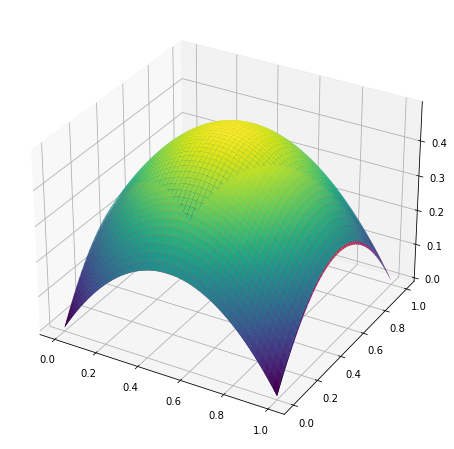

In [106]:
Nx = 50
Ny = 50
eps = 0.0001
tau = 0.01
equation = Equation(lambda y: y*(1-y), lambda y: y*(1-y), lambda x: x*(1-x), lambda x: x*(1-x), lambda x,y: 4)
u = equation.solve_equation(Nx,Ny,tau, eps)

x = np.zeros(Nx)
for i in range (Nx):
    x[i] = i/(Nx-1)
y = np.zeros(Ny)
for i in range (Ny):
    y[i] = i/(Ny-1)
X,Y = np.meshgrid(x,y)

u_ac_func = lambda x,y: x*(1-x) + y*(1-y)
u_ac = np.zeros((Nx,Ny)) 
for i in range (Nx):
    for j in range (Ny):
        u_ac[i,j] = u_ac_func(x[i],y[j])

print('Норма ошибки =',get_error_norm(u, u_ac))
fig = plt.figure()
plt.figure(figsize=((8,8)))
ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,u_ac,cmap ='viridis') #Точное решение
ax.plot_surface(X,Y,u,cmap='inferno') #Приближенное решение
plt.show()